In [1]:
import os
import requests
import numpy as np
import xarray as xr
import hmp
from mne.io import read_info
import matplotlib.pyplot as plt

# Declaring path where the EEG data will be stored
epoch_data_path = os.path.join('sample_data', 'eeg')
os.makedirs(epoch_data_path, exist_ok=True)

# URLs of the first 5 participants in the SAT experiment, navigate the osf folder and adapt those if you want to do this tutorial on other data (e.g. P3, N2pc)
file_urls = [
    "https://osf.io/download/92n3g/",
    "https://osf.io/download/fdqc7/",
    "https://osf.io/download/ezfdq/",
    "https://osf.io/download/4zu35/",
    "https://osf.io/download/d8432/",
    "https://osf.io/download/p2c4k/",
]

# Download and save each file if not already in folder
for i, url in enumerate(file_urls, start=1):
    file_path = os.path.join(epoch_data_path, f'participant{i}_epo.fif')
    if not os.path.exists(file_path):
        response = requests.get(url)
        with open(file_path, 'wb') as f:
            f.write(response.content)

# Recovering individual files and participant names
subj_files = [os.path.join(epoch_data_path, f) for f in os.listdir(epoch_data_path) if f.endswith('.fif')]  # Create a list of files with full paths
subj_names = [os.path.splitext(f)[0] for f in os.listdir(epoch_data_path) if f.endswith('.fif')]  # Extract subject names based on file names

# Recovering channel information (assuming the same for all participant)
info = read_info(subj_files[0], verbose=False)

# Importing an example epoch file just to show the format, of the metadata
import mne
epochs = mne.read_epochs(os.path.join(epoch_data_path,os.listdir(epoch_data_path)[0]))
epochs.metadata

Reading /home/gabriel/ownCloud/projects/unil/HMP_practicalMEEG/sample_data/eeg/participant3_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    3000.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
1116 matching events found
No baseline correction applied
0 projection items activated


,event_name,rt,condition,side,stimulus,response
0,stimulus/46,2.317383,accuracy,right,46,left
1,stimulus/86,1.400391,accuracy,right,86,right
2,stimulus/82,2.425781,accuracy,right,82,left
3,stimulus/87,1.318359,accuracy,left,87,left
4,stimulus/45,1.049805,accuracy,right,45,right
...,...,...,...,...,...,...
1111,stimulus/10,0.536133,speed,right,10,right
1112,stimulus/53,0.495117,speed,right,53,right
1113,stimulus/74,0.545898,speed,left,74,right
1114,stimulus/57,0.360352,speed,right,57,left


In [2]:
# At what frequency we want the data, upsample only if you have a large amount of RAM (and time)
# Note that upsampling usually doesn't improve the results, it is however useful if you want to use patterns that are shorter than the standard 50ms Halfsines
sfreq = 250

# Then we read the data as shown in Tutorial 1
epoch_data = hmp.io.read_mne_data(subj_files, data_format='epochs', sfreq=sfreq,
                            lower_limit_rt=0.2, upper_limit_rt=2,
                            reject_threshold=1e-4,
                            rt_col = 'rt', scale = 1, #In this case the rts are contained in the dataframe column "RT" and is in milliseconds, thus we adapt
                            verbose=False, subj_name=subj_names)#Turning verbose off for the documentation but it is recommended to leave it on as some output from MNE might be useful

print(epoch_data)

Processing participant sample_data/eeg/participant3_epo.fif's epochs eeg
12 trials rejected based on threshold of 0.0001
1030 trials were retained for participant sample_data/eeg/participant3_epo.fif
Processing participant sample_data/eeg/participant4_epo.fif's epochs eeg
0 trials rejected based on threshold of 0.0001
1085 trials were retained for participant sample_data/eeg/participant4_epo.fif
Processing participant sample_data/eeg/participant5_epo.fif's epochs eeg
3 trials rejected based on threshold of 0.0001
1099 trials were retained for participant sample_data/eeg/participant5_epo.fif
Processing participant sample_data/eeg/participant1_epo.fif's epochs eeg
5 trials rejected based on threshold of 0.0001
1089 trials were retained for participant sample_data/eeg/participant1_epo.fif
Processing participant sample_data/eeg/participant6_epo.fif's epochs eeg
2 trials rejected based on threshold of 0.0001
1097 trials were retained for participant sample_data/eeg/participant6_epo.fif
Proc

In [3]:
preprocessed = hmp.preprocessing.Standard(epoch_data, n_comp=10)
# Defining the expected HMP pattern
event_properties = hmp.patterns.HalfSine.create_expected(sfreq=epoch_data.sfreq)
# Performing the crosscorrelation between the preprocessed data and the expected pattern
trial_data = hmp.trialdata.TrialData.from_preprocessed(preprocessed=preprocessed, pattern=event_properties.template)

/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/preprocessing.py:186: UserWarning: Data will be modified inplace, re-read the data or use copy=True if multiplecalls to this function
  warn(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/preprocessing.py:368: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


In [4]:
model = hmp.models.CumulativeMethod(event_properties)
_, estimates_cumulative = model.fit_transform(trial_data)

  0%|          | 0/158 [00:00<?, ?it/s]

Transition event 1 found around time 128.0
Transition event 2 found around time 320.0
Transition event 3 found around time 584.0

All events found, refitting final combination.
Estimating 3 events model


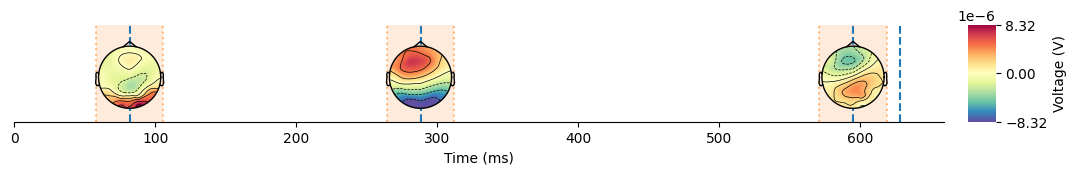

In [5]:
hmp.visu.plot_topo_timecourse(epoch_data, estimates_cumulative, info, as_time=True)

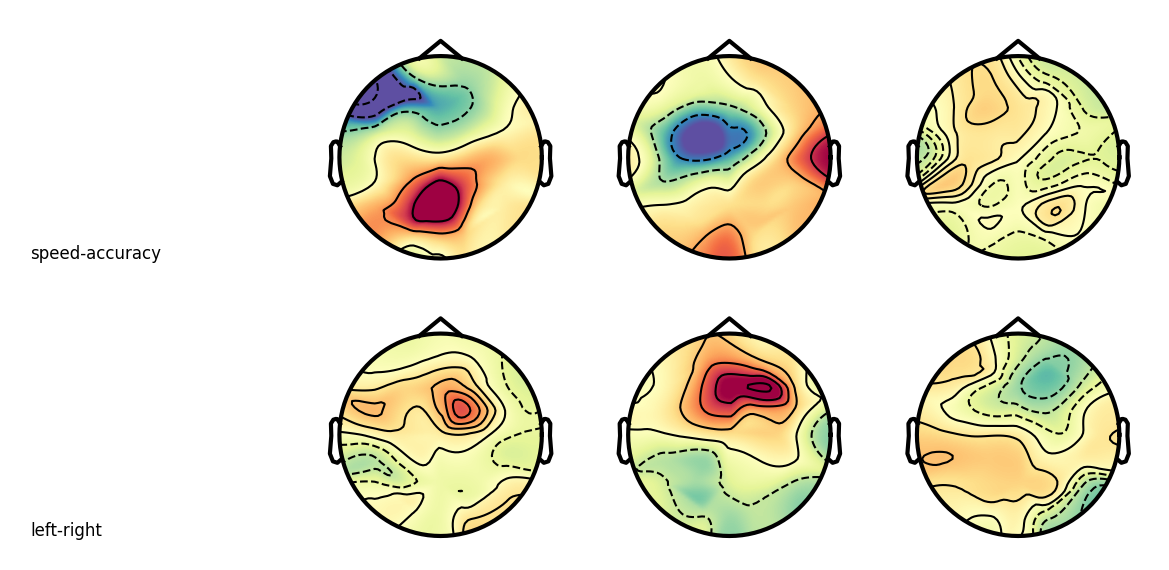

In [6]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from mne.viz import plot_topomap, plot_montage
bin_diff = [{'condition':['speed','accuracy']},
           {'side':['left', 'right']}]

fig, ax = plt.subplots(len(bin_diff), len(estimates_cumulative.event)+1, figsize=(len(estimates_cumulative.event)+1,len(bin_diff)), dpi=300)

for d, diff in enumerate(bin_diff):
    a = hmp.utils.condition_selection_epoch(epoch_data, list(diff.values())[0][0], variable=list(diff.keys())[0])
    b = hmp.utils.condition_selection_epoch(epoch_data, list(diff.values())[0][1], variable=list(diff.keys())[0])
    a = hmp.utils.event_channels(a, estimates_cumulative, mean=False).unstack().mean('epoch')
    b = hmp.utils.event_channels(b, estimates_cumulative, mean=False).unstack().mean('epoch')

    for event in a.event:
        t_vals = np.zeros(a.sizes['channel'])
        for c, channel in enumerate(a.channel):
            t_val, _ = ttest_1samp(a.sel(event=event, channel=channel) - b.sel(event=event, channel=channel), popmean=0)
            t_vals[c] = t_val
        _ = plot_topomap(t_vals, info, axes=ax[d, event+1], show=False, sensors=False, cmap='Spectral_r', vlim=(-5, 5))
    ax[d, 0].text(0,0, str(list(diff.values())[0][0])+ '-' + list(diff.values())[0][1], rotation=0, fontsize=4)
    ax[d, 0].axis('off')
plt.tight_layout()